[View in Colaboratory](https://colab.research.google.com/github/pmanlukas/colab/blob/master/openapi_classifier.ipynb)

# openAPI spec classifier
This notebook is used to create a first proof of concept on a classifier for openAPI files. The classifier will be based on a neural network based architecture and will be implemented in Tensorflow, SciPy and Keras.

In [2]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setting up python-apt (1.4.0~beta3build2) ...
Setting up python3-dbus (1.2.4-1build3) ...
Setting up python-software-properties (0.96.24.17) ...
Setting up softwar

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [4]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# Create a folder to use for the project data
!mkdir -p /content/drive/openapi-data/

In [10]:
!ls /content/drive/openapi-data/

glove.6B.zip  path_labels.csv  structure_labels.csv
mnist.py      pickle	       wordvector


In [11]:
!pip install -q keras
!pip install -q graphviz
import keras
import graphviz

Using TensorFlow backend.


In [12]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [13]:
!apt-get -qq install -y libarchive-dev && pip install -q -U libarchive
import libarchive

Selecting previously unselected package liblzo2-2:amd64.
(Reading database ... 19735 files and directories currently installed.)
Preparing to unpack .../liblzo2-2_2.08-1.2_amd64.deb ...
Unpacking liblzo2-2:amd64 (2.08-1.2) ...
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../libarchive13_3.2.2-3.1_amd64.deb ...
Unpacking libarchive13:amd64 (3.2.2-3.1) ...
Selecting previously unselected package libarchive-dev:amd64.
Preparing to unpack .../libarchive-dev_3.2.2-3.1_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up liblzo2-2:amd64 (2.08-1.2) ...
Setting up libarchive13:amd64 (3.2.2-3.1) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...


In [0]:
import os
os.chdir("drive/openapi-data")

In [15]:
!ls

glove.6B.zip  path_labels.csv  structure_labels.csv
mnist.py      pickle	       wordvector


In [0]:
import pickle

In [0]:
training_data = dict()

with open('pickle/specs.pkl', 'rb') as handle:
    training_data = pickle.load(handle)

In [0]:
keys = list(training_data.keys())

In [19]:
training_data[keys[0]]

{'basePath': '/forex-quotes',
 'host': '1forge.com',
 'info': {'contact': {'email': 'contact@1forge.com',
   'name': '1Forge',
   'url': 'http://1forge.com'},
  'description': 'Stock and Forex Data and Realtime Quotes',
  'title': '1Forge Finance APIs',
  'version': '0.0.1',
  'x-apisguru-categories': ['financial'],
  'x-logo': {'backgroundColor': '#24292e',
   'url': 'https://api.apis.guru/v2/cache/logo/http_1forge.com_logo.png'},
  'x-origin': [{'format': 'swagger',
    'url': 'http://1forge.com/openapi.json',
    'version': '2.0'}],
  'x-preferred': True,
  'x-providerName': '1forge.com'},
 'paths': {'/quotes': {'get': {'description': 'Get quotes',
    'externalDocs': {'description': 'Find out more',
     'url': 'http://1forge.com/forex-data-api'},
    'responses': {'200': {'description': 'A list of quotes'}},
    'summary': 'Get quotes for all symbols',
    'tags': ['forex', 'finance', 'quotes']}},
  '/symbols': {'get': {'description': 'Symbol List',
    'externalDocs': {'descripti

In [0]:
from collections import Counter
from datetime import datetime
 
import json
 
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
 
import numpy as np
import pandas as pd

In [21]:
!ls

glove.6B.zip  path_labels.csv  structure_labels.csv
mnist.py      pickle	       wordvector


In [0]:
labelsP = pd.read_csv("path_labels.csv").values
labelsS  = pd.read_csv("structure_labels.csv").values

In [23]:
labelsS.shape



(1016, 2)

In [24]:
labelsS

array([['1forge.com', 1],
       ['6-dot-authentiqio.appspot.com', 1],
       ['adafruit.com', 2],
       ...,
       ['zoom.us', 4],
       ['zoomconnect.com', 3],
       ['zuora.com', 3]], dtype=object)

## test word embeddings

In [26]:
texts = []   # list of text samples
for spec in training_data:
  strJson = json.dumps(training_data[spec])
  texts.append(strJson)

print(str(len(texts)))

1016


In [27]:
print(type(texts[0]))
print(texts[0])

<class 'str'>
{"swagger": "2.0", "schemes": ["https", "http"], "host": "1forge.com", "basePath": "/forex-quotes", "info": {"contact": {"email": "contact@1forge.com", "name": "1Forge", "url": "http://1forge.com"}, "description": "Stock and Forex Data and Realtime Quotes", "title": "1Forge Finance APIs", "version": "0.0.1", "x-apisguru-categories": ["financial"], "x-logo": {"backgroundColor": "#24292e", "url": "https://api.apis.guru/v2/cache/logo/http_1forge.com_logo.png"}, "x-origin": [{"format": "swagger", "url": "http://1forge.com/openapi.json", "version": "2.0"}], "x-preferred": true, "x-providerName": "1forge.com"}, "produces": ["application/json"], "paths": {"/quotes": {"get": {"description": "Get quotes", "externalDocs": {"description": "Find out more", "url": "http://1forge.com/forex-data-api"}, "responses": {"200": {"description": "A list of quotes"}}, "summary": "Get quotes for all symbols", "tags": ["forex", "finance", "quotes"]}}, "/symbols": {"get": {"description": "Symbol L

In [68]:


labels = labelsStruct  # list of label ids
print(type(labels))
print(labels)

<class 'list'>
[1, 1, 2, 2, 1, 1, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 3, 5, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 1, 1, 2, 3, 1, 4, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [36]:
labelsP = labelsPath  # list of label ids
print(type(labels))
print(labels)

<class 'list'>
[1, 1, 2, 2, 1, 1, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 3, 5, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 1, 1, 2, 3, 1, 4, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [69]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

encoder = LabelBinarizer()
encoder.fit(labels)
y_train = encoder.transform(labels)

y_train

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [66]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

encoder = LabelBinarizer()
encoder.fit(labelsP)
yp_train = encoder.transform(labelsP)

yp_train

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [0]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

In [0]:
MAX_SEQUENCE_LENGTH = 50000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [72]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = y_train #keras.utils.to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

/usr/local/lib/python3.6/dist-packages/keras/preprocessing/text.py:172: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 146890 unique tokens.
Shape of data tensor: (1016, 50000)
Shape of label tensor: (1016, 6)


In [73]:
y_train

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1]])

In [74]:
embeddings_index = {}
f = open(os.path.join('wordvector', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, LSTM

In [0]:
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import regularizers
from keras.callbacks import ModelCheckpoint


sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, kernel_regularizer=regularizers.l2(0.01), activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 5, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 5, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)
preds = Dense(6, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])



In [0]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [138]:
summary = model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 50000)             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50000, 100)        2000000   
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 49996, 128)        64128     
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 9999, 128)         0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 9999, 128)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 9995, 128)         82048     
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 1999, 128)         0         
__________

In [139]:
# happy learning!
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    verbose=1,
                    validation_split=0.2, callbacks=callbacks_list)

Train on 650 samples, validate on 163 samples
Epoch 1/50
650/650 [==============================] - 17s 26ms/step - loss: 10.4184 - acc: 0.3185 - val_loss: 7.9125 - val_acc: 0.3313

Epoch 00001: val_acc improved from -inf to 0.33129, saving model to weights.best.hdf5
Epoch 2/50
650/650 [==============================] - 15s 23ms/step - loss: 6.5585 - acc: 0.3338 - val_loss: 5.2612 - val_acc: 0.3681

Epoch 00002: val_acc improved from 0.33129 to 0.36810, saving model to weights.best.hdf5
Epoch 3/50
650/650 [==============================] - 15s 23ms/step - loss: 4.4756 - acc: 0.3354 - val_loss: 3.6619 - val_acc: 0.3681

Epoch 00003: val_acc did not improve from 0.36810
Epoch 4/50
650/650 [==============================] - 15s 23ms/step - loss: 3.2114 - acc: 0.4385 - val_loss: 2.7140 - val_acc: 0.5890

Epoch 00004: val_acc improved from 0.36810 to 0.58896, saving model to weights.best.hdf5
Epoch 5/50
650/650 [==============================] - 15s 23ms/step - loss: 2.4510 - acc: 0.5231 - 

650/650 [==============================] - 15s 23ms/step - loss: 1.6522 - acc: 0.6123 - val_loss: 1.5082 - val_acc: 0.5644

Epoch 00007: val_acc did not improve from 0.59509
Epoch 8/50
650/650 [==============================] - 15s 23ms/step - loss: 1.5100 - acc: 0.5923 - val_loss: 1.3590 - val_acc: 0.6748

Epoch 00008: val_acc improved from 0.59509 to 0.67485, saving model to weights.best.hdf5
Epoch 9/50
650/650 [==============================] - 15s 23ms/step - loss: 1.3026 - acc: 0.6538 - val_loss: 1.2589 - val_acc: 0.6687

Epoch 00009: val_acc did not improve from 0.67485
Epoch 10/50
650/650 [==============================] - 15s 23ms/step - loss: 1.2037 - acc: 0.6954 - val_loss: 1.1768 - val_acc: 0.6994

Epoch 00010: val_acc improved from 0.67485 to 0.69939, saving model to weights.best.hdf5
Epoch 11/50
650/650 [==============================] - 15s 23ms/step - loss: 1.1691 - acc: 0.6969 - val_loss: 1.1885 - val_acc: 0.6564

Epoch 00011: val_acc did not improve from 0.69939
Epoch 

650/650 [==============================] - 15s 23ms/step - loss: 1.1558 - acc: 0.6954 - val_loss: 1.1798 - val_acc: 0.7362

Epoch 00013: val_acc did not improve from 0.76074
Epoch 14/50
650/650 [==============================] - 15s 23ms/step - loss: 1.2148 - acc: 0.6985 - val_loss: 1.1231 - val_acc: 0.7362

Epoch 00014: val_acc did not improve from 0.76074
Epoch 15/50
650/650 [==============================] - 15s 23ms/step - loss: 1.0409 - acc: 0.7646 - val_loss: 1.0233 - val_acc: 0.7546

Epoch 00015: val_acc did not improve from 0.76074
Epoch 16/50
650/650 [==============================] - 15s 23ms/step - loss: 0.9865 - acc: 0.7646 - val_loss: 0.9499 - val_acc: 0.7607

Epoch 00016: val_acc improved from 0.76074 to 0.76074, saving model to weights.best.hdf5
Epoch 17/50
650/650 [==============================] - 15s 23ms/step - loss: 0.8621 - acc: 0.8308 - val_loss: 0.9397 - val_acc: 0.7485

Epoch 00017: val_acc did not improve from 0.76074
Epoch 18/50
650/650 [======================

650/650 [==============================] - 15s 23ms/step - loss: 0.8005 - acc: 0.8200 - val_loss: 1.1117 - val_acc: 0.7669

Epoch 00019: val_acc improved from 0.76074 to 0.76687, saving model to weights.best.hdf5
Epoch 20/50
650/650 [==============================] - 15s 23ms/step - loss: 0.7953 - acc: 0.8415 - val_loss: 1.0465 - val_acc: 0.7423

Epoch 00020: val_acc did not improve from 0.76687
Epoch 21/50
650/650 [==============================] - 15s 23ms/step - loss: 0.7857 - acc: 0.8600 - val_loss: 0.9544 - val_acc: 0.7914

Epoch 00021: val_acc improved from 0.76687 to 0.79141, saving model to weights.best.hdf5
Epoch 22/50
650/650 [==============================] - 15s 23ms/step - loss: 0.7587 - acc: 0.8677 - val_loss: 0.9941 - val_acc: 0.7669

Epoch 00022: val_acc did not improve from 0.79141
Epoch 23/50
650/650 [==============================] - 15s 23ms/step - loss: 0.7619 - acc: 0.8462 - val_loss: 0.9773 - val_acc: 0.7730

Epoch 00023: val_acc did not improve from 0.79141
Epoc

650/650 [==============================] - 15s 23ms/step - loss: 0.7615 - acc: 0.8631 - val_loss: 1.0082 - val_acc: 0.7669

Epoch 00025: val_acc did not improve from 0.79141
Epoch 26/50
650/650 [==============================] - 15s 23ms/step - loss: 0.7611 - acc: 0.8831 - val_loss: 1.2237 - val_acc: 0.7239

Epoch 00026: val_acc did not improve from 0.79141
Epoch 27/50
650/650 [==============================] - 15s 23ms/step - loss: 0.7872 - acc: 0.8646 - val_loss: 1.0469 - val_acc: 0.7791

Epoch 00027: val_acc did not improve from 0.79141
Epoch 28/50
650/650 [==============================] - 15s 23ms/step - loss: 0.7147 - acc: 0.8954 - val_loss: 1.0266 - val_acc: 0.8160

Epoch 00028: val_acc improved from 0.79141 to 0.81595, saving model to weights.best.hdf5
Epoch 29/50
650/650 [==============================] - 15s 23ms/step - loss: 0.8351 - acc: 0.8615 - val_loss: 1.0668 - val_acc: 0.7791

Epoch 00029: val_acc did not improve from 0.81595
Epoch 30/50
650/650 [======================

650/650 [==============================] - 15s 23ms/step - loss: 0.6068 - acc: 0.9508 - val_loss: 1.0872 - val_acc: 0.7914

Epoch 00031: val_acc did not improve from 0.81595
Epoch 32/50
650/650 [==============================] - 15s 23ms/step - loss: 0.5865 - acc: 0.9400 - val_loss: 1.1589 - val_acc: 0.7607

Epoch 00032: val_acc did not improve from 0.81595
Epoch 33/50
650/650 [==============================] - 15s 23ms/step - loss: 0.6047 - acc: 0.9246 - val_loss: 1.0727 - val_acc: 0.7914

Epoch 00033: val_acc did not improve from 0.81595
Epoch 34/50
650/650 [==============================] - 15s 23ms/step - loss: 0.5742 - acc: 0.9308 - val_loss: 1.1123 - val_acc: 0.7669

Epoch 00034: val_acc did not improve from 0.81595
Epoch 35/50
650/650 [==============================] - 15s 23ms/step - loss: 0.5763 - acc: 0.9400 - val_loss: 1.1727 - val_acc: 0.7607

Epoch 00035: val_acc did not improve from 0.81595
Epoch 36/50
650/650 [==============================] - 15s 23ms/step - loss: 0.546

650/650 [==============================] - 15s 23ms/step - loss: 0.5251 - acc: 0.9446 - val_loss: 1.0705 - val_acc: 0.7669

Epoch 00038: val_acc did not improve from 0.81595
Epoch 39/50
650/650 [==============================] - 15s 23ms/step - loss: 0.5107 - acc: 0.9508 - val_loss: 1.1398 - val_acc: 0.7730

Epoch 00039: val_acc did not improve from 0.81595
Epoch 40/50
650/650 [==============================] - 15s 23ms/step - loss: 0.5232 - acc: 0.9354 - val_loss: 1.0357 - val_acc: 0.7607

Epoch 00040: val_acc did not improve from 0.81595
Epoch 41/50
650/650 [==============================] - 15s 23ms/step - loss: 0.5142 - acc: 0.9492 - val_loss: 1.2087 - val_acc: 0.7546

Epoch 00041: val_acc did not improve from 0.81595
Epoch 42/50
650/650 [==============================] - 15s 23ms/step - loss: 0.5167 - acc: 0.9508 - val_loss: 1.1079 - val_acc: 0.7791

Epoch 00042: val_acc did not improve from 0.81595
Epoch 43/50
650/650 [==============================] - 15s 23ms/step - loss: 0.574

650/650 [==============================] - 15s 23ms/step - loss: 0.7328 - acc: 0.8969 - val_loss: 1.0734 - val_acc: 0.7669

Epoch 00045: val_acc did not improve from 0.81595
Epoch 46/50
650/650 [==============================] - 15s 23ms/step - loss: 0.6877 - acc: 0.9046 - val_loss: 1.1288 - val_acc: 0.7730

Epoch 00046: val_acc did not improve from 0.81595
Epoch 47/50
650/650 [==============================] - 15s 23ms/step - loss: 0.6265 - acc: 0.9215 - val_loss: 1.0087 - val_acc: 0.7914

Epoch 00047: val_acc did not improve from 0.81595
Epoch 48/50
650/650 [==============================] - 15s 23ms/step - loss: 0.5355 - acc: 0.9569 - val_loss: 0.9635 - val_acc: 0.7853

Epoch 00048: val_acc did not improve from 0.81595
Epoch 49/50
650/650 [==============================] - 15s 23ms/step - loss: 0.5124 - acc: 0.9569 - val_loss: 1.0886 - val_acc: 0.7730

Epoch 00049: val_acc did not improve from 0.81595
Epoch 50/50
650/650 [==============================] - 15s 23ms/step - loss: 0.525

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


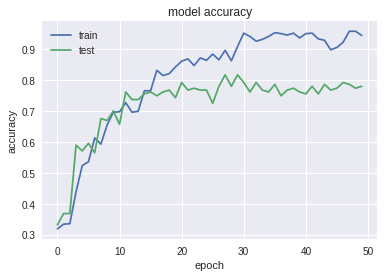

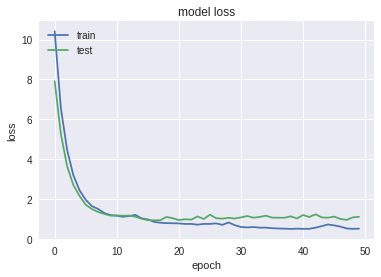

In [140]:
import matplotlib.pyplot as plt
import numpy

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.load_weights("weights.best.hdf5")
# Compile model (required to make predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [142]:
score = model.evaluate(x_val, y_val,
                       batch_size=32, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

203/203 [==============================] - 3s 15ms/step
Test score: 1.1849711775192486
Test accuracy: 0.7684729061103219


In [0]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [0]:
y_softmax = model.predict(x_val)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_val)):
    probs = y_val[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [145]:
print(y_test_1d)
print(y_pred_1d)

[1, 5, 3, 0, 0, 1, 3, 5, 3, 5, 4, 2, 4, 5, 1, 0, 2, 4, 5, 4, 2, 4, 4, 3, 5, 4, 3, 3, 3, 3, 4, 3, 5, 1, 3, 0, 5, 5, 5, 5, 5, 5, 0, 5, 4, 5, 2, 3, 2, 5, 1, 2, 0, 2, 0, 3, 2, 1, 3, 3, 4, 5, 4, 0, 0, 5, 5, 4, 5, 3, 2, 5, 5, 5, 5, 1, 5, 3, 0, 5, 5, 3, 3, 0, 5, 5, 3, 4, 0, 4, 3, 1, 3, 3, 1, 1, 5, 1, 0, 5, 1, 4, 0, 5, 1, 1, 5, 2, 0, 5, 3, 4, 3, 5, 3, 5, 4, 1, 3, 2, 1, 0, 2, 3, 0, 4, 0, 2, 3, 0, 5, 0, 5, 3, 4, 0, 3, 3, 3, 3, 1, 5, 5, 1, 5, 0, 0, 4, 0, 5, 2, 5, 3, 5, 0, 0, 5, 5, 0, 2, 5, 5, 3, 5, 0, 5, 3, 5, 5, 5, 2, 5, 1, 3, 2, 1, 5, 3, 4, 1, 3, 5, 0, 4, 1, 2, 4, 1, 0, 4, 4, 1, 4, 1, 5, 5, 5, 3, 5, 5, 4, 5, 4]
[1, 5, 3, 3, 0, 5, 3, 5, 3, 5, 4, 2, 1, 5, 1, 0, 3, 4, 5, 4, 2, 4, 4, 0, 5, 4, 1, 3, 3, 3, 4, 3, 5, 1, 3, 2, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 0, 3, 2, 5, 3, 2, 0, 0, 1, 3, 2, 2, 2, 1, 4, 5, 4, 0, 0, 5, 5, 4, 5, 3, 2, 5, 5, 5, 5, 1, 5, 2, 0, 5, 5, 3, 3, 0, 5, 5, 3, 4, 2, 4, 3, 1, 4, 3, 1, 1, 5, 1, 2, 5, 2, 3, 1, 5, 2, 1, 5, 2, 0, 5, 3, 4, 3, 5, 3, 5, 4, 5, 3, 2, 1, 1, 0, 0, 0, 4, 0, 0, 3, 1,

## Prepare Labels and Specs for the model
In this part of the notebook, we will create three list. One contains the specs and the other two the labels for paths and for specs. The lists are later used as input for the actual preprocessing and then later the model.

In [29]:
labelsPath = list()
labelsStruct = list()


for labs in labelsS:
  labelsStruct.append(labs[1])

for labp in labelsP:
  labelsPath.append(labp[1])
  
print(str(len(labelsPath)))
print(str(len(labelsStruct)))

#labelsStruct = labelsS["cluster"].tolist()

1016
1016


In [30]:
print(labelsPath)
print(labelsStruct)

[1, 2, 3, 4, 5, 6, 7, 4, 4, 8, 3, 6, 8, 3, 4, 8, 6, 2, 4, 4, 2, 8, 6, 3, 4, 4, 8, 4, 9, 4, 4, 3, 3, 3, 4, 4, 6, 4, 8, 3, 9, 4, 4, 3, 3, 4, 3, 3, 3, 10, 4, 3, 3, 3, 8, 3, 3, 3, 4, 6, 1, 8, 4, 8, 6, 4, 6, 3, 3, 2, 6, 2, 3, 6, 9, 9, 4, 5, 1, 4, 8, 3, 4, 3, 6, 3, 3, 5, 4, 8, 8, 8, 9, 9, 8, 1, 4, 8, 3, 6, 4, 3, 3, 2, 9, 6, 6, 3, 8, 2, 3, 4, 5, 1, 6, 3, 8, 8, 6, 4, 8, 8, 4, 3, 4, 6, 4, 6, 2, 8, 4, 3, 9, 1, 6, 6, 3, 3, 4, 2, 3, 2, 6, 6, 4, 7, 1, 7, 7, 1, 7, 7, 7, 7, 7, 5, 1, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 2, 7, 7, 2, 7, 7, 7, 2, 3, 5, 1, 8, 3, 9, 2, 4, 9, 2, 8, 9, 4, 9, 9, 9, 8, 2, 9, 2, 9, 9, 1, 2, 9, 8, 9, 5, 2, 2, 7, 4, 2, 2, 9, 7, 5, 5, 9, 9, 5, 5, 9, 9, 7, 9, 8, 7, 2, 8, 2, 9, 9, 5, 9, 9, 9, 2, 5, 5, 2, 5, 7, 2, 8, 9, 5, 1, 1, 9, 5, 9, 9, 5, 7, 1, 1, 1, 1, 1, 9, 5, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 7, 5, 5, 9, 4, 8, 9, 4, 2, 2, 4, 4, 6, 1, 5, 1, 3, 9, 8, 5, 7, 7, 9, 9, 8, 9, 7, 9, 4, 3, 9, 3, 4, 3, 2, 8, 5, 4, 8, 6, 2, 9, 4, 4, 5, 5, 7, 9,

### Create training and test split of the labels

In [0]:
Y_Path_train = labelsPath[:808]
Y_Path_test = labelsPath[808:]

Y_Struct_train = labelsStruct[:808]
Y_Struct_test = labelsStruct[808:]

In [0]:
print(len(Y_Path_train))
print(len(Y_Path_test))
print(len(Y_Struct_train))
print(len(Y_Struct_test))

In [0]:
with open('pickle/Y_Path_train.pickle', 'wb') as handle:
    pickle.dump(Y_Path_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('pickle/Y_Path_test.pickle', 'wb') as handle:
    pickle.dump(Y_Path_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('pickle/Y_Struct_train.pickle', 'wb') as handle:
    pickle.dump(Y_Struct_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('pickle/Y_Struct_test.pickle', 'wb') as handle:
    pickle.dump(Y_Struct_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
specs_json = list()

In [0]:
import json

In [0]:
for spec in training_data:
  strJson = json.dumps(training_data[spec])
  specs_json.append(strJson)

print(str(len(specs_json)))
  
  

In [0]:
specs_json[1]

In [0]:
X_train = specs_json[:808]
X_test = specs_json[808:]

print(len(X_train))
print(len(X_test))

## Preprocessing
In this part of the notebook we are going to preprocess the data itself. The data will be tokenized, preprocessed and stored as Training and Test sets

In [0]:
from keras.preprocessing.text import Tokenizer

Once fit, the Tokenizer provides 4 attributes that you can use to query what has been learned about your documents:

*   word_counts: A dictionary of words and their counts.
*   word_docs: A dictionary of words and how many documents each appeared in.
*   word_index: A dictionary of words and their uniquely assigned integers.
*   document_count:An integer count of the total number of documents that were used to fit the Tokenizer.


[source](https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/)


In [0]:
tokenizer = Tokenizer(num_words=10000,filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')

tokenizer

tokenizer.fit_on_texts(specs_json)



x_train = tokenizer.texts_to_matrix(X_train)
x_test = tokenizer.texts_to_matrix(X_test)

--------------------------------

In [0]:
x_train

In [0]:
x_test

In [0]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

encoder = LabelBinarizer()
encoder.fit(labelsStruct)
y_train = encoder.transform(Y_Struct_train)
y_test = encoder.transform(Y_Struct_test)

In [0]:
y_train

In [0]:
len(x_train[0])

In [0]:
print('y_train shape:', y_train.shape)

In [0]:
print('x_train shape:', x_train.shape)

In [0]:
batch_size = 32
epochs = 2

---------------------------------------------------------------

## Model Architecture
In this section of the notebook the actual deep learning model is designed and the architecture presented before the actual training of it will take place.

In [0]:
model = Sequential()
model.add(Embedding(10000, 128, input_length=10000))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax',name = 'softmax_layer'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
print(model.summary())

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=3,
                    verbose=1,
                    validation_split=0.2)

In [0]:
model2 = Sequential()
model2.add(Dense(512, input_shape=(10000,)))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dense(6))
model2.add(Activation('softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
print(model2.summary())

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model2.png')

In [0]:
history2 = model2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=15,
                    verbose=1,
                    validation_split=0.2)

### first training

In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [0]:
score = model2.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [0]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)


In [0]:
loss_and_metrics = model2.evaluate(x_test, y_test, batch_size=128)


### Use Model

In [0]:
classes = model.predict(x_test, batch_size=128)


In [0]:
classes2 = model2.predict(x_test, batch_size=128)

### Evaluation

In [0]:
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

In [0]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [0]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()